# Litteraturbanken Author 
version 1.20 -  added link json 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * video Swedish
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

#### Other sources we sync
* [Arken](https://github.com/salgo60/open-data-examples/blob/master/Arken.ipynb) 
  * WD [Property:P8899](https://www.wikidata.org/wiki/Property:P8899) 
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2021-10-05 08:05:58.507253


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
400,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1633340749553,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,NaN,NaN,NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['full_name'] = row['full_name']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['full_name','authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   full_name                4046 non-null   object        
 1   authorid                 4046 non-null   object        
 2   wd_hos_Litteraturbanken  2359 non-null   object        
 3   authorid_norm            4046 non-null   object        
 4   show                     4046 non-null   bool          
 5   updated                  3388 non-null   datetime64[ns]
 6   imported                 3388 non-null   datetime64[ns]
 7   librisid                 2180 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(5)
memory usage: 225.3+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     3174
False     872
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 1 to 4045
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   full_name                3174 non-null   object        
 1   authorid                 3174 non-null   object        
 2   wd_hos_Litteraturbanken  2358 non-null   object        
 3   authorid_norm            3174 non-null   object        
 4   show                     3174 non-null   bool          
 5   updated                  2730 non-null   datetime64[ns]
 6   imported                 2730 non-null   datetime64[ns]
 7   librisid                 1783 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(5)
memory usage: 201.5+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:70]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Karl Wetterhoff,WetterhoffK,Q6238678,WetterhoffK,True,2022-02-22,2022-02-22,NaN
1,Johan Oskar Immanuel Rancken,RanckenJOI,Q6062983,RanckenJOI,True,2022-02-22,2022-02-22,nl0254c60nr1vp2
2,Élisa Girod-Hoskier,GirodHoskierE,Q108365232,GirodHoskierE,True,2022-02-22,2022-02-22,NaN
3,René Descartes,DescartesR,Q9191,DescartesR,True,2022-02-22,2022-02-22,nl02209622nvnn9
4,Paul Valéry,ValéryP,Q200639,ValeryP,True,2022-02-22,2022-02-22,zw9cd3sh1pn39ck
...,...,...,...,...,...,...,...,...
65,Mårten Triewald,TriewaldM,Q363197,TriewaldM,True,2021-08-30,2021-08-30,1zcfg4gk21f492v
66,Richard Head,HeadR,NaN,HeadR,True,2021-08-30,2021-08-30,20dgk72l2jh45gd
67,Anna Preinitz,PreinitzA,NaN,PreinitzA,True,2021-08-30,2021-08-30,NaN
68,Pelle Hedman,HedmanP,Q5796301,HedmanP,True,2021-08-30,2021-08-30,NaN


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:410]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Karl Wetterhoff,WetterhoffK,Q6238678,WetterhoffK,True,2022-02-22,2022-02-22,NaN
1,Élisa Girod-Hoskier,GirodHoskierE,Q108365232,GirodHoskierE,True,2022-02-22,2022-02-22,NaN
2,René Descartes,DescartesR,Q9191,DescartesR,True,2022-02-22,2022-02-22,nl02209622nvnn9
3,Paul Valéry,ValéryP,Q200639,ValeryP,True,2022-02-22,2022-02-22,zw9cd3sh1pn39ck
4,Jessie Bröchner,BröchnerJ,Q108365371,BrochnerJ,True,2022-02-22,2022-02-22,NaN
...,...,...,...,...,...,...,...,...
405,Aurore Silfverskjöld,SilfverskjöldA,NaN,SilfverskjoldA,True,2021-04-06,2021-04-06,NaN
406,Adolf Schirmer,SchirmerA,NaN,SchirmerA,True,2021-04-06,2021-04-06,NaN
407,Gustaf Holdo Stråle,StråleGH,Q6192949,StraleGH,True,2021-04-06,2021-04-06,ljx14rh41k5xn3q
408,Erik Anders Rosenius,RoseniusEA,NaN,RoseniusEA,True,2021-04-06,2021-04-06,mkz25hd52cdd9t2


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  2373 non-null   object
 1   authorid    2373 non-null   object
dtypes: object(2)
memory usage: 37.2+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    3
authorid      3
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("WahlinKr")]

,WikidataID,authorid


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
780,Q108365232,GirodHoskierE,Élisa Girod-Hoskier,Q108365232,GirodHoskierE,True,2022-02-22,2022-02-22,NaN,both
514,Q9191,DescartesR,René Descartes,Q9191,DescartesR,True,2022-02-22,2022-02-22,nl02209622nvnn9,both
2263,Q6238678,WetterhoffK,Karl Wetterhoff,Q6238678,WetterhoffK,True,2022-02-22,2022-02-22,NaN,both
2177,Q200639,ValéryP,Paul Valéry,Q200639,ValeryP,True,2022-02-22,2022-02-22,zw9cd3sh1pn39ck,both
1664,Q106611599,PalmérF,Fritiof Palmér,Q106611599,PalmerF,True,2022-02-22,2022-02-22,NaN,both
359,Q108365371,BröchnerJ,Jessie Bröchner,Q108365371,BrochnerJ,True,2022-02-22,2022-02-22,NaN,both
1734,Q6062983,RanckenJOI,Johan Oskar Immanuel Rancken,Q6062983,RanckenJOI,True,2022-02-22,2022-02-22,nl0254c60nr1vp2,both
2387,NaN,KrookNathalia,Nathalia Krook,NaN,KrookNathalia,True,2021-10-04,2021-10-04,NaN,Litterturbanken_only
2389,NaN,QvistO,O. Qvist,NaN,QvistO,True,2021-10-04,2021-10-04,NaN,Litterturbanken_only
2388,NaN,JanzonN,Nils Janzon,NaN,JanzonN,True,2021-10-04,2021-10-04,NaN,Litterturbanken_only


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176 entries, 780 to 3175
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               2373 non-null   object        
 1   authorid                 3176 non-null   object        
 2   full_name                3174 non-null   object        
 3   wd_hos_Litteraturbanken  2358 non-null   object        
 4   authorid_norm            3174 non-null   object        
 5   show                     3174 non-null   object        
 6   updated                  2730 non-null   datetime64[ns]
 7   imported                 2730 non-null   datetime64[ns]
 8   librisid                 1783 non-null   object        
 9   WD_Litteraturbanken      3176 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 272.9+ KB


In [19]:
dfmerge["show"].value_counts()

True    3174
Name: show, dtype: int64

### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [20]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    2371
Litterturbanken_only     803
WD_only                    2
Name: WD_Litteraturbanken, dtype: int64

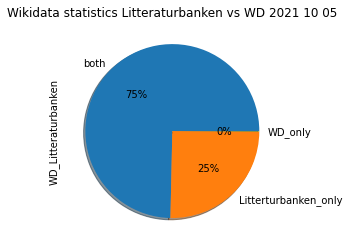

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [22]:
mergeCheckNumber

both                    2371
Litterturbanken_only     803
WD_only                    2
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [23]:
#mergewithLibris

In [24]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [25]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1783 entries, 514 to 1751
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1627 non-null   object        
 1   authorid                 1783 non-null   object        
 2   full_name                1783 non-null   object        
 3   wd_hos_Litteraturbanken  1602 non-null   object        
 4   authorid_norm            1783 non-null   object        
 5   show                     1783 non-null   object        
 6   updated                  1783 non-null   datetime64[ns]
 7   imported                 1783 non-null   datetime64[ns]
 8   librisid                 1783 non-null   object        
 9   WD_Litteraturbanken      1783 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 153.2+ KB


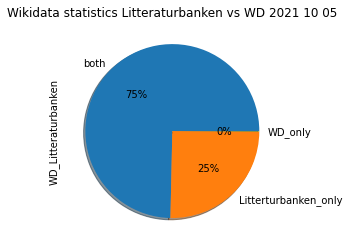

In [26]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [27]:
mergeCheckNumber

both                    2371
Litterturbanken_only     803
WD_only                    2
Name: WD_Litteraturbanken, dtype: int64

In [28]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1588
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               2 non-null      object        
 1   authorid                 2 non-null      object        
 2   full_name                0 non-null      object        
 3   wd_hos_Litteraturbanken  0 non-null      object        
 4   authorid_norm            0 non-null      object        
 5   show                     0 non-null      object        
 6   updated                  0 non-null      datetime64[ns]
 7   imported                 0 non-null      datetime64[ns]
 8   librisid                 0 non-null      object        
 9   WD_Litteraturbanken      2 non-null      object        
dtypes: datetime64[ns](2), object(8)
memory usage: 176.0+ bytes


In [29]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   full_name                3174 non-null   object        
 1   authorid                 3174 non-null   object        
 2   wd_hos_Litteraturbanken  2358 non-null   object        
 3   authorid_norm            3174 non-null   object        
 4   show                     3174 non-null   bool          
 5   updated                  2730 non-null   datetime64[ns]
 6   imported                 2730 non-null   datetime64[ns]
 7   librisid                 1783 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(5)
memory usage: 176.8+ KB


In [30]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3175 entries, 0 to 3174
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 2 non-null      object        
 1   authorid_x                 2 non-null      object        
 2   full_name_x                0 non-null      object        
 3   wd_hos_Litteraturbanken_x  0 non-null      object        
 4   authorid_norm_x            0 non-null      object        
 5   show_x                     0 non-null      object        
 6   updated_x                  0 non-null      datetime64[ns]
 7   imported_x                 0 non-null      datetime64[ns]
 8   librisid_x                 0 non-null      object        
 9   WD_Litteraturbanken        2 non-null      object        
 10  full_name_y                3174 non-null   object        
 11  authorid_y                 3174 non-null   object        
 12  wd_hos

In [31]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

In [32]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [33]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 
df[df['authorid'].str.contains("AdlersparreCA")] 


,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
12,AdlersparreCA,AdlersparreCA,{'plain': '1810'},ee8800f1bf02a701963b901a12e726c0,1633340751365,"{'date': '1862', 'plain': '1862'}",author,Carl August Adlersparre,male,2021-03-01,None,sq4677hb49x6bfd,"Adlersparre, Carl August",None,True,True,Adlersparre,2021-03-01,"{'birthplace': [14.1166, 59.3106], 'birthplace...",1.633341e+12,NaN,246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [34]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,WikidataID,authorid_y,show_y,authorid_x
0,Q108802239,NorénV,True,NorenV


In [35]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

,authorid,Littbank,WikidataID
0,336,link,Q105674275
1588,NorenV,link,Q108802239


In [36]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [37]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 1 non-null      object        
 1   authorid_x                 1 non-null      object        
 2   full_name_x                0 non-null      object        
 3   wd_hos_Litteraturbanken_x  0 non-null      object        
 4   authorid_norm_x            0 non-null      object        
 5   show_x                     0 non-null      object        
 6   updated_x                  0 non-null      datetime64[ns]
 7   imported_x                 0 non-null      datetime64[ns]
 8   librisid_x                 0 non-null      object        
 9   WD_Litteraturbanken        1 non-null      object        
 10  Littbank                   1 non-null      object        
 11  full_name_y                1 non-null      object        
 12  authorid_y  

In [38]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,full_name_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,full_name_y,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q108802239,NorenV,NaN,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Victor Norén,NorénV,NaN,NorenV,True,2021-03-01,2021-03-01,53hlqwdp0ctlmc0,both


In [39]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [40]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    2371
Litterturbanken_only     803
WD_only                    2
Name: WD_Litteraturbanken, dtype: int64

In [41]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 2387 to 3175
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 803 non-null    object        
 2   full_name                803 non-null    object        
 3   wd_hos_Litteraturbanken  12 non-null     object        
 4   authorid_norm            803 non-null    object        
 5   show                     803 non-null    object        
 6   updated                  564 non-null    datetime64[ns]
 7   imported                 564 non-null    datetime64[ns]
 8   librisid                 156 non-null    object        
 9   WD_Litteraturbanken      803 non-null    object        
dtypes: datetime64[ns](2), object(8)
memory usage: 69.0+ KB


In [42]:
Litterturbanken_only.to_csv("LitteraturbankenAuthor_new.csv")
# LitteraturbankenAuthor_new.csv

In [43]:
#Litterturbanken_only

* See latest checked [LitteraturbankenAuthor_new.csv in GITHUB](https://github.com/salgo60/open-data-examples/blob/master/LitteraturbankenAuthor_new.csv)

In [44]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                   0
authorid                   156
full_name                  156
wd_hos_Litteraturbanken      0
authorid_norm              156
show                       156
updated                    156
imported                   156
librisid                   156
WD_Litteraturbanken        156
dtype: int64

## Errors funna nedan 
* Show True borde det inte vara False?: Eugénie BerglindhU EngeströmL Rafael WestinF 
* Dublett: NordinCG / NordinC , ArfvidssonN / ArfwidssonN 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [45]:
Litterturbanken_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 2387 to 3175
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 803 non-null    object        
 2   full_name                803 non-null    object        
 3   wd_hos_Litteraturbanken  12 non-null     object        
 4   authorid_norm            803 non-null    object        
 5   show                     803 non-null    object        
 6   updated                  564 non-null    datetime64[ns]
 7   imported                 564 non-null    datetime64[ns]
 8   librisid                 156 non-null    object        
 9   WD_Litteraturbanken      803 non-null    object        
dtypes: datetime64[ns](2), object(8)
memory usage: 69.0+ KB


In [46]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'full_name','WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy() 
Litterturbanken_onlyW["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
Litterturbanken_onlyW.shape


(156, 8)

In [47]:
HTML(Litterturbanken_onlyW.to_html(escape=False))


,WikidataID,show,librisid,WD_Litteraturbanken,full_name,authorid,Littbank,LittbankJSON
2376,NaN,True,nl037l361944826,Litterturbanken_only,Gunnar Berndtson,BerndtsonG,link Litteraturbanken,json
2377,NaN,True,rp3529m957b52w9,Litterturbanken_only,J. Ohlsson,OhlssonJ,link Litteraturbanken,json
2378,NaN,True,jgvx1jd2523jkck,Litterturbanken_only,Olivus Olán,OlánO,link Litteraturbanken,json
2379,NaN,True,tr58dfcc2f7m50m,Litterturbanken_only,William Anderson,AndersonW,link Litteraturbanken,json
2380,NaN,True,42gjmmxn29mvqh1,Litterturbanken_only,Harald Waxberg,WaxbergH,link Litteraturbanken,json
2373,NaN,True,86lnhbvs3f0dx3s,Litterturbanken_only,Jenny Blicher-Clausen,BlicherClausenJ,link Litteraturbanken,json
2400,NaN,True,pm148pd73c92sl6,Litterturbanken_only,Jean Nicolas Bouilly,BouillyJN,link Litteraturbanken,json
2399,NaN,True,wt79ddxf5q5d42r,Litterturbanken_only,Felice Romani,RomaniF,link Litteraturbanken,json
2891,NaN,True,wt79cr7f196118n,Litterturbanken_only,Berhard Severin Ingemann,IngemannBS,link Litteraturbanken,json
2398,NaN,True,b8nqtlvv150xcfs,Litterturbanken_only,Jean François Marmontel,MarmontelJF,link Litteraturbanken,json


In [48]:
Litterturbanken_onlyW.to_csv("LitteraturbankenAuthorWD_new.csv")

In [49]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [50]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [51]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [52]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     2373
right_only     872
both             0
Name: _merge, dtype: int64

In [53]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata


In [54]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 0 non-null      object        
 2   full_name                0 non-null      object        
 3   wd_hos_Litteraturbanken  0 non-null      object        
 4   authorid_norm            0 non-null      object        
 5   show                     0 non-null      object        
 6   updated                  0 non-null      datetime64[ns]
 7   imported                 0 non-null      datetime64[ns]
 8   librisid                 0 non-null      object        
 9   Littbank                 0 non-null      object        
 10  LittbankJSON             0 non-null      object        
 11  Wikidata                 0 non-null      object        
dtypes: datetime64[ns](2), object(10)
memory usage: 0

In [55]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','DobbinL','HallbergP','JonssonErnst',
                                    'NordlingS','BerggrenH','AustenJ',
                                             'BjörnbergE'
                                             
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))


## Problem records that has show false

In [56]:
ErrorShowFalseLitteraturbank["Litteraturbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + ErrorShowFalseLitteraturbank["authorid"] + "'>link</a>"
ErrorShowFalseLitteraturbank["get_author"] = "<a href='https://litteraturbanken.se/api/get_author/" + ErrorShowFalseLitteraturbank["authorid"] + "'>get_author</a>"

ErrorShowFalseLitteraturbank.sort_values(by=['authorid'],inplace=True, ascending=[True])
HTML(ErrorShowFalseLitteraturbank.to_html(escape=False))


,authorid,Litteraturbank,get_author
11,AustenJ,link,get_author
10,BerggrenH,link,get_author
0,BirchPfeifferC,link,get_author
1,BjörkmanE,link,get_author
12,BjörnbergE,link,get_author
6,DobbinL,link,get_author
7,HallbergP,link,get_author
8,JonssonErnst,link,get_author
9,NordlingS,link,get_author
2,RomanusAlfvénAC,link,get_author


## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

**Lessom learned** we have bots that update from Litteraturbanken that sometimes add a mess....

In [57]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,authorid,_merge


In [58]:
# Indicates that this member shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,authorid,_merge
0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,BirchPfeifferC,right_only
1,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,BjörkmanE,right_only
2,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,RomanusAlfvénAC,right_only
3,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,SjödinS,right_only
4,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,TirénG,right_only
5,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,ÅströmP,right_only
6,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,DobbinL,right_only
7,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,HallbergP,right_only
8,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,JonssonErnst,right_only
9,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NordlingS,right_only


In [59]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

Ended:  2021-10-05 08:06:06.286273
Time elapsed (hh:mm:ass.ms) 0:00:07.779354
